<a href="https://www.kaggle.com/code/mdjakaria69/fraud-detection-cse445-original-vs-smote-gan?scriptVersionId=228919075" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraudulent-e-commerce-transactions/Fraudulent_E-Commerce_Transaction_Data.csv
/kaggle/input/fraudulent-e-commerce-transactions/Fraudulent_E-Commerce_Transaction_Data_2.csv


# **Checking if GPU is available**

In [2]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA Available: True
GPU Name: Tesla T4


> ***If GPU is available, then list them down***

In [3]:
!nvidia-smi

Fri Mar 21 16:49:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Data Loading and Preprocessing with Visualization**

Class Distribution:
 Is Fraudulent
0    1399114
1      73838
Name: count, dtype: int64


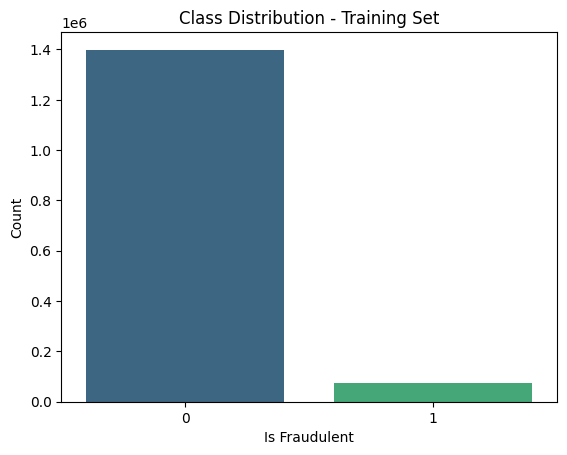

Preprocessing completed successfully!


In [4]:
# Imports and warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load dataset
train_df = pd.read_csv('/kaggle/input/fraudulent-e-commerce-transactions/Fraudulent_E-Commerce_Transaction_Data.csv')
test_df = pd.read_csv('/kaggle/input/fraudulent-e-commerce-transactions/Fraudulent_E-Commerce_Transaction_Data_2.csv')

# Preprocessing function
def clean_data(df) -> pd.DataFrame:
    df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
    df['Transaction Day'] = df["Transaction Date"].dt.day
    df["Transaction DOW"] = df["Transaction Date"].dt.day_of_week
    df["Transaction Month"] = df["Transaction Date"].dt.month
    
    mean_value = np.round(df['Customer Age'].mean(), 0) 
    df['Customer Age'] = np.where(df['Customer Age'] <= -9, 
                                    np.abs(df['Customer Age']), 
                                    df['Customer Age'])
    df['Customer Age'] = np.where(df['Customer Age'] < 9, 
                                    mean_value, 
                                    df['Customer Age'])
    df["Is Address Match"] = (df["Shipping Address"] == df["Billing Address"]).astype(int)
    
    df.drop(columns=["Transaction ID", "Customer ID", "Customer Location",
                     "IP Address", "Transaction Date", "Shipping Address", "Billing Address"], inplace=True)
    
    int_col = df.select_dtypes(include="int").columns
    float_col = df.select_dtypes(include="float").columns
    df[int_col] = df[int_col].apply(pd.to_numeric, downcast='integer')
    df[float_col] = df[float_col].apply(pd.to_numeric, downcast='float')
    
    return df

# Clean training and test data
train_df = clean_data(train_df)
test_df = clean_data(test_df)

# Split features and target
X = train_df.drop(columns=['Is Fraudulent'])
y = train_df['Is Fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution
class_counts = train_df['Is Fraudulent'].value_counts()
print("Class Distribution:\n", class_counts)

# Plot class distribution
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution - Training Set")
plt.xlabel("Is Fraudulent")
plt.ylabel("Count")
plt.show()

# Separate categorical and numerical columns
cat_col = X_train.select_dtypes(include="O").columns
num_col = [col for col in X_train.columns if col not in cat_col and col != 'Is Address Match']

# Apply OneHotEncoder for categorical features and StandardScaler for numerical features
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col),
    ('num', StandardScaler(), num_col)
])

# Transform X_train to numerical
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Preprocessing completed successfully!")

# Applying Smote to remove Class Imbalance

Class Distribution After SMOTE:
 Is Fraudulent
0    1119285
1    1119285
Name: count, dtype: int64


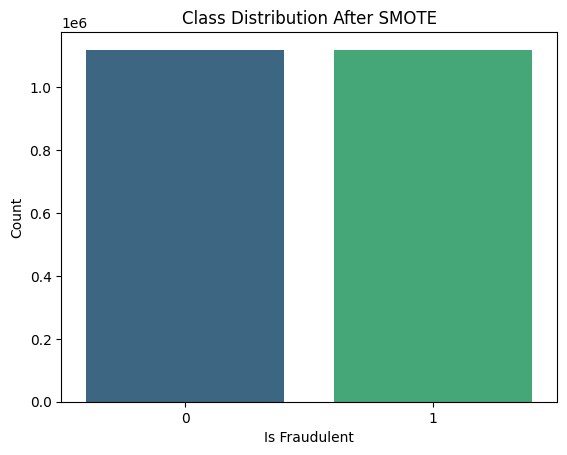

In [5]:
# Apply SMOTE on transformed data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

# Check results
smote_counts = pd.Series(y_train_smote).value_counts()
print("Class Distribution After SMOTE:\n", smote_counts)

# Visualize the distribution
sns.barplot(x=smote_counts.index, y=smote_counts.values, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Is Fraudulent")
plt.ylabel("Count")
plt.show()

# ***Training and Evaluating 3 different ML models on Original and SMOTE data separately***


Random Forest - Original Data
Accuracy: 0.953964627231954
Confusion Matrix:
 [[22355    57]
 [ 1031   191]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     22412
           1       0.77      0.16      0.26      1222

    accuracy                           0.95     23634
   macro avg       0.86      0.58      0.62     23634
weighted avg       0.95      0.95      0.94     23634



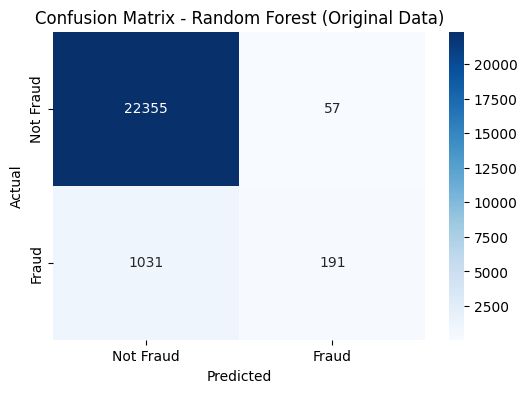


Logistic Regression - Original Data
Accuracy: 0.9532030126089532
Confusion Matrix:
 [[22386    26]
 [ 1080   142]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     22412
           1       0.85      0.12      0.20      1222

    accuracy                           0.95     23634
   macro avg       0.90      0.56      0.59     23634
weighted avg       0.95      0.95      0.94     23634



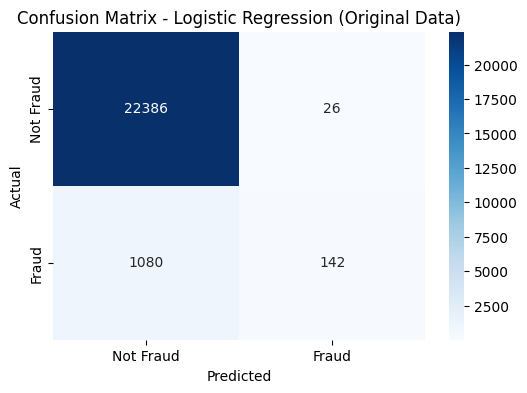


XGBoost - Original Data
Accuracy: 0.9541338749259541
Confusion Matrix:
 [[22363    49]
 [ 1035   187]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     22412
           1       0.79      0.15      0.26      1222

    accuracy                           0.95     23634
   macro avg       0.87      0.58      0.62     23634
weighted avg       0.95      0.95      0.94     23634



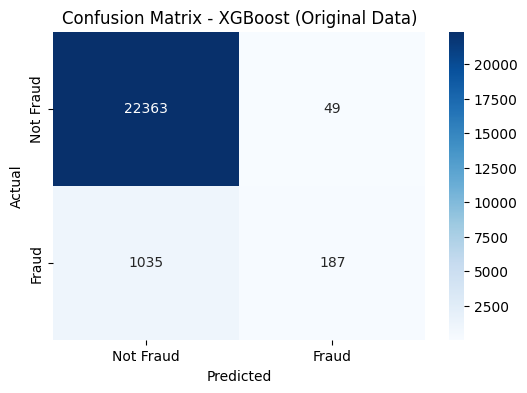


Random Forest - SMOTE Data
Accuracy: 0.9466023525429466
Confusion Matrix:
 [[22025   387]
 [  875   347]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     22412
           1       0.47      0.28      0.35      1222

    accuracy                           0.95     23634
   macro avg       0.72      0.63      0.66     23634
weighted avg       0.94      0.95      0.94     23634



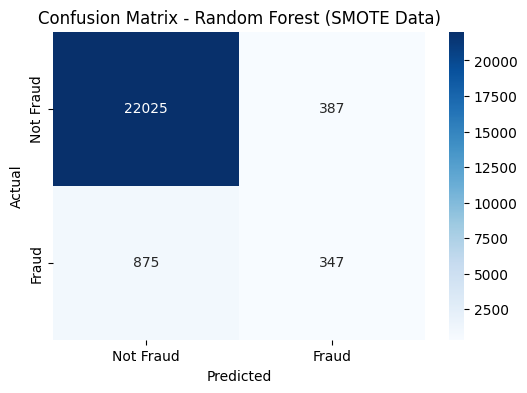


Logistic Regression - SMOTE Data
Accuracy: 0.7183295252602183
Confusion Matrix:
 [[16134  6278]
 [  379   843]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83     22412
           1       0.12      0.69      0.20      1222

    accuracy                           0.72     23634
   macro avg       0.55      0.70      0.52     23634
weighted avg       0.93      0.72      0.80     23634



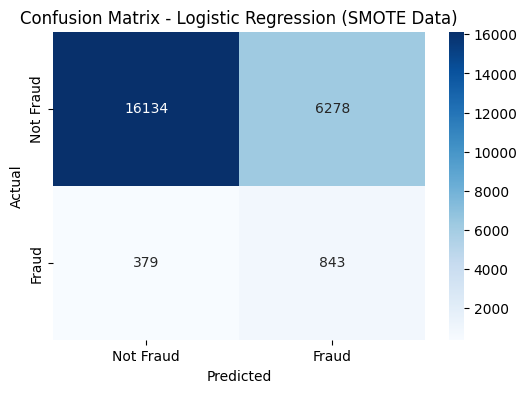


XGBoost - SMOTE Data
Accuracy: 0.9525260218329525
Confusion Matrix:
 [[22285   127]
 [  995   227]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     22412
           1       0.64      0.19      0.29      1222

    accuracy                           0.95     23634
   macro avg       0.80      0.59      0.63     23634
weighted avg       0.94      0.95      0.94     23634



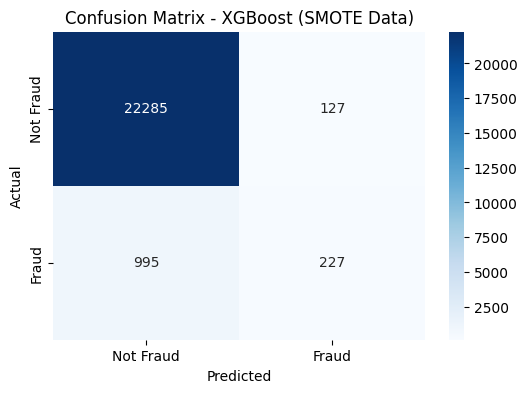

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  # Using Logistic Regression for classification
from xgboost import XGBClassifier

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),  # Used instead of Linear Regression
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}

# Train models
def train_and_evaluate(X_train, y_train, X_test, y_test, desc):
    results = []
    for name, classifier in classifiers.items():
        model = Pipeline(steps=[
            ('classifier', classifier)
        ])
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        cm = confusion_matrix(y_test, preds)
        
        print(f"\n{name} - {desc}")
        print("Accuracy:", acc)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", classification_report(y_test, preds))
        
        # Plot heatmap
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name} ({desc})')
        plt.show()
        
        results.append((name, acc))
    return results

# Transform test data
X_test_transformed = preprocessor.transform(test_df.drop(columns=["Is Fraudulent"]))

# Train models on original and SMOTE data
results_original = train_and_evaluate(X_train_transformed, y_train, X_test_transformed, test_df["Is Fraudulent"], "Original Data")
results_smote = train_and_evaluate(X_train_smote, y_train_smote, X_test_transformed, test_df["Is Fraudulent"], "SMOTE Data")

# ***Comparing results against Original Data vs SMOTE Data***


Comparison of Results:
                 Model  Accuracy (Original)  Accuracy (SMOTE)
0        Random Forest             0.953965          0.946602
1  Logistic Regression             0.953203          0.718330
2              XGBoost             0.954134          0.952526


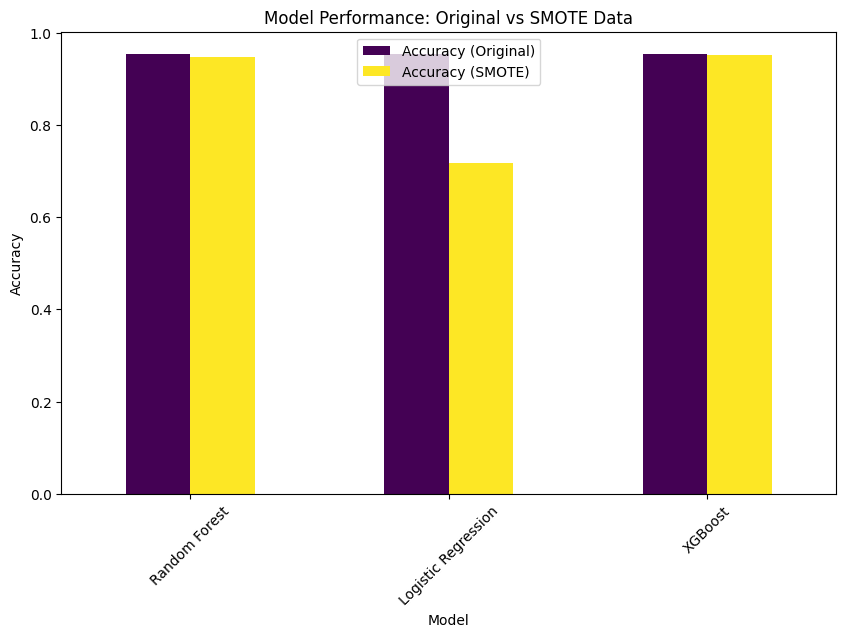

In [7]:
# Combine results into a DataFrame
comparison_df = pd.DataFrame({
    "Model": [r[0] for r in results_original],
    "Accuracy (Original)": [r[1] for r in results_original],
    "Accuracy (SMOTE)": [r[1] for r in results_smote],
})

print("\nComparison of Results:")
print(comparison_df)

# Plot results
comparison_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance: Original vs SMOTE Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

# ***Applying GAN on Preprocessed Original data, then Training and Evaluating 3 different models***

Epoch 0: D Loss: 1.0116276741027832, G Loss: 1.7356709241867065
Epoch 20: D Loss: 1.440466284751892, G Loss: 0.7608192563056946
Epoch 40: D Loss: 1.3669960498809814, G Loss: 0.7013799548149109
Epoch 60: D Loss: 1.3847622871398926, G Loss: 0.6865983605384827
Epoch 80: D Loss: 1.3098485469818115, G Loss: 0.7708571553230286
X_train_transformed shape: (2356722, 20)
y_train_augmented shape: (2356722,)
X_test_transformed shape: (23634, 20)
y_test shape: (23634,)

Running Original Data training:
X_train shape: (1178361, 20), y_train shape: (1178361,)
X_test shape: (23634, 20), y_test shape: (23634,)

Random Forest - Original Data
Accuracy: 0.9538800033849539


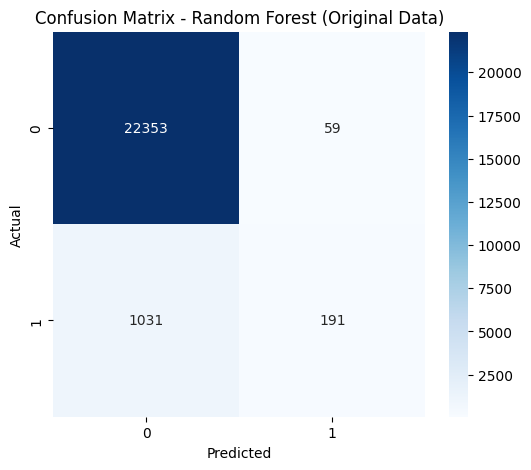

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     22412
           1       0.76      0.16      0.26      1222

    accuracy                           0.95     23634
   macro avg       0.86      0.58      0.62     23634
weighted avg       0.95      0.95      0.94     23634


Logistic Regression - Original Data
Accuracy: 0.9532030126089532


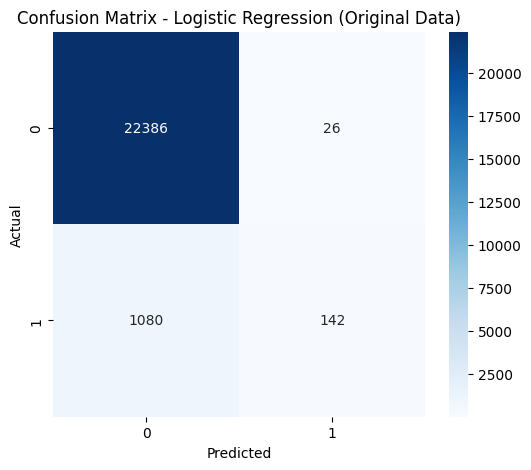

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     22412
           1       0.85      0.12      0.20      1222

    accuracy                           0.95     23634
   macro avg       0.90      0.56      0.59     23634
weighted avg       0.95      0.95      0.94     23634


XGBoost - Original Data
Accuracy: 0.9541338749259541


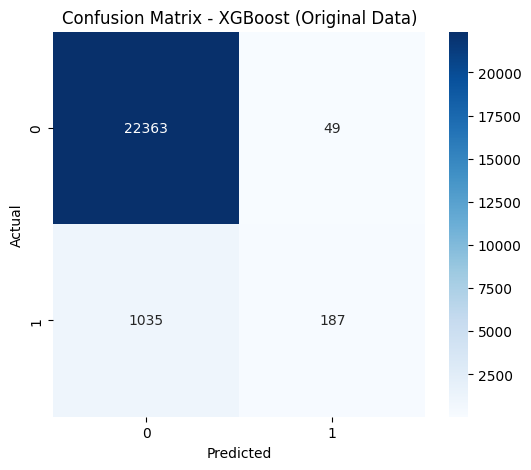

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     22412
           1       0.79      0.15      0.26      1222

    accuracy                           0.95     23634
   macro avg       0.87      0.58      0.62     23634
weighted avg       0.95      0.95      0.94     23634


Running GAN Data training:
X_train shape: (2356722, 20), y_train shape: (2356722,)
X_test shape: (23634, 20), y_test shape: (23634,)

Random Forest - GAN Data
Accuracy: 0.9541761868494542


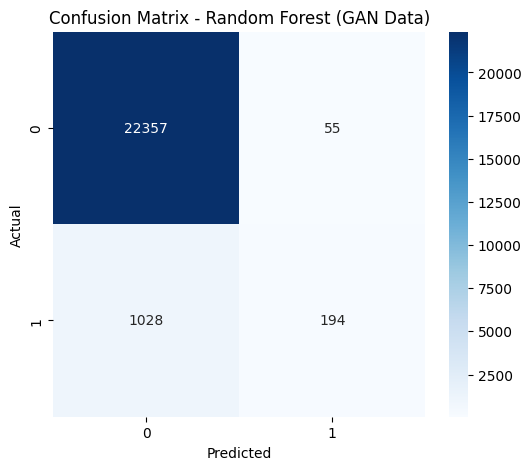

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     22412
           1       0.78      0.16      0.26      1222

    accuracy                           0.95     23634
   macro avg       0.87      0.58      0.62     23634
weighted avg       0.95      0.95      0.94     23634


Logistic Regression - GAN Data
Accuracy: 0.9276466108149276


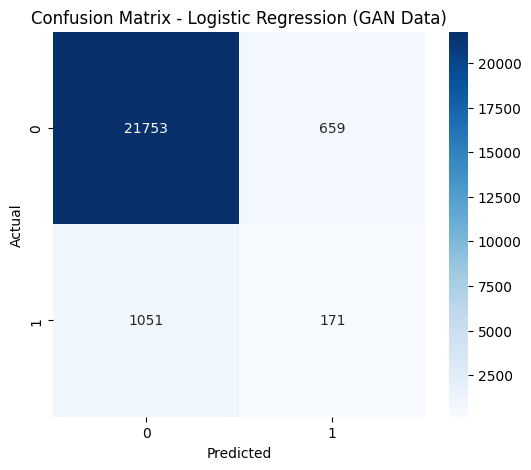

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96     22412
           1       0.21      0.14      0.17      1222

    accuracy                           0.93     23634
   macro avg       0.58      0.56      0.56     23634
weighted avg       0.92      0.93      0.92     23634


XGBoost - GAN Data
Accuracy: 0.953922315308454


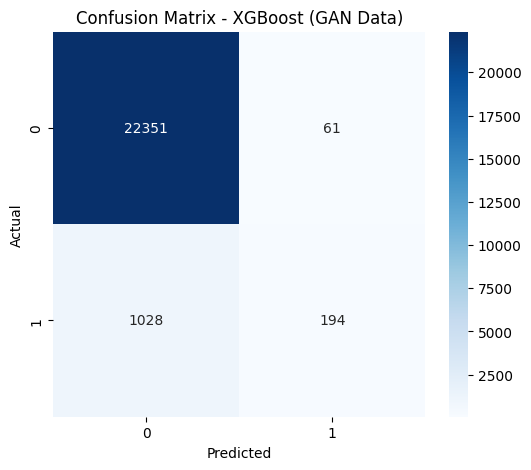

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     22412
           1       0.76      0.16      0.26      1222

    accuracy                           0.95     23634
   macro avg       0.86      0.58      0.62     23634
weighted avg       0.95      0.95      0.94     23634


Updated Comparison of Results:
                 Model  Accuracy (Original)  Accuracy (GAN)
0        Random Forest             0.953880        0.954176
1  Logistic Regression             0.953203        0.927647
2              XGBoost             0.954134        0.953922


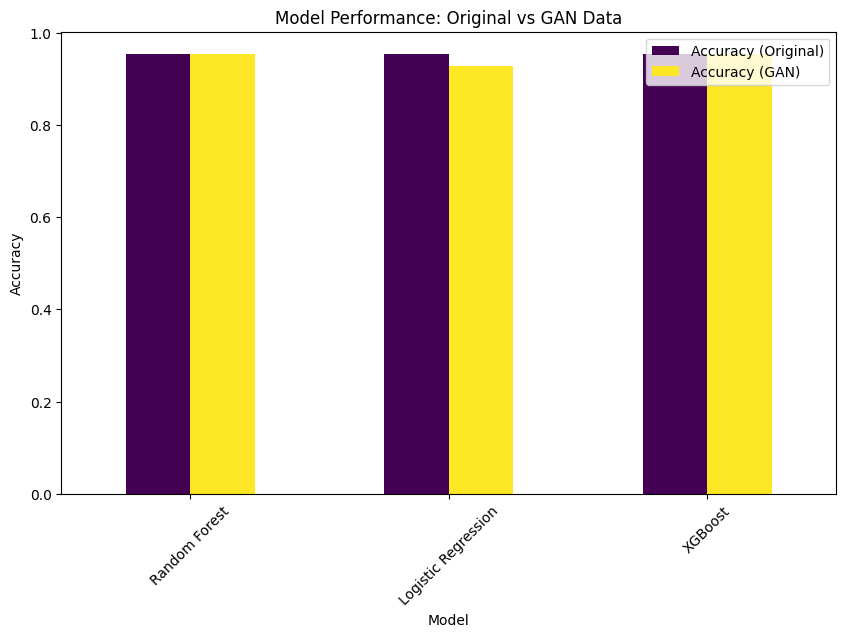

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Keep all columns, including categorical
X_train_selected = X_train.copy()

# Convert only numeric features to tensors
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_train_tensor = torch.tensor(X_train_numeric.to_numpy().astype(np.float32)).to(device)
y_train_tensor = torch.tensor(y_train.to_numpy().astype(np.float32)).to(device)

input_dim = X_train_numeric.shape[1]

# Define Simple Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, z):
        return self.model(z)

# Define Simple Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# GAN Hyperparameters
latent_dim = input_dim // 2
gen = Generator(latent_dim, input_dim).to(device)
disc = Discriminator(input_dim).to(device)
criterion = nn.BCELoss()
gen_opt = optim.Adam(gen.parameters(), lr=0.001)
disc_opt = optim.Adam(disc.parameters(), lr=0.001)

num_epochs = 100  
batch_size = 256  

# Create DataLoader
dataloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

# Train GAN
for epoch in range(num_epochs):
    for real_samples, _ in dataloader:
        batch_size = real_samples.shape[0]
        real_samples = real_samples.to(device)

        # Train Discriminator
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        
        real_preds = disc(real_samples)
        real_loss = criterion(real_preds, real_labels)
        
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_samples = gen(noise)
        fake_preds = disc(fake_samples.detach())
        fake_loss = criterion(fake_preds, fake_labels)
        
        disc_loss = real_loss + fake_loss
        disc_opt.zero_grad()
        disc_loss.backward()
        disc_opt.step()
        
        # Train Generator
        fake_preds = disc(fake_samples)
        gen_loss = criterion(fake_preds, real_labels)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: D Loss: {disc_loss.item()}, G Loss: {gen_loss.item()}")

# Generate synthetic samples
num_synthetic_samples = len(y_train)
noise = torch.randn(num_synthetic_samples, latent_dim, device=device)
synthetic_samples = gen(noise).detach().cpu().numpy()
synthetic_labels = np.ones((num_synthetic_samples,))  # Ensure correct shape

# Convert synthetic samples to DataFrame with correct numeric column names
X_synthetic_df = pd.DataFrame(synthetic_samples, columns=X_train_numeric.columns)

# Restore missing categorical columns
for col in X_train.columns:
    if col not in X_synthetic_df.columns:
        X_synthetic_df[col] = X_train[col].mode()[0]  # Fill with most common category

# Append synthetic data to original dataset
X_train_augmented = pd.concat([X_train_selected, X_synthetic_df], ignore_index=True)
y_train_augmented = np.hstack((y_train.to_numpy(), synthetic_labels))

# Apply preprocessing pipeline
X_train_transformed = preprocessor.fit_transform(X_train_augmented)
X_test_transformed = preprocessor.transform(test_df.drop(columns=["Is Fraudulent"]))

# Debugging statements
print("X_train_transformed shape:", X_train_transformed.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("X_test_transformed shape:", X_test_transformed.shape)
print("y_test shape:", test_df["Is Fraudulent"].shape)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  # Using Logistic Regression for classification
from xgboost import XGBClassifier

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),  # Used instead of Linear Regression
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}

# Define confusion matrix function for all

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(set(y_true))  # Dynamically get class labels
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()


def train_and_evaluate(X_train, y_train, X_test, y_test, desc):
    print(f"\nRunning {desc} training:")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    results = []
    for name, classifier in classifiers.items():
        model = Pipeline(steps=[('classifier', classifier)])
        try:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            print(f"\n{name} - {desc}")
            print("Accuracy:", acc)
            plot_confusion_matrix(y_test, preds, f"{name} ({desc})")
            print("Classification Report:\n", classification_report(y_test, preds))
            results.append((name, acc))
        except ValueError as e:
            print(f"Error in {name} training: {e}")
    return results


# Train models on original and augmented data
# Ensure original dataset is used for "Original Data"
results_original = train_and_evaluate(
    X_train_transformed[:len(y_train)],  # Match the length of original y_train
    y_train, 
    X_test_transformed, 
    test_df["Is Fraudulent"], 
    "Original Data"
)

# Train models on augmented data
results_gan = train_and_evaluate(
    X_train_transformed, 
    y_train_augmented, 
    X_test_transformed, 
    test_df["Is Fraudulent"], 
    "GAN Data"
)


# Compare results
comparison_df = pd.DataFrame({
    "Model": [r[0] for r in results_gan],
    "Accuracy (Original)": [r[1] for r in results_original],
    "Accuracy (GAN)": [r[1] for r in results_gan],
})
print("\nUpdated Comparison of Results:")
print(comparison_df)

# Plot updated results
comparison_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance: Original vs GAN Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

# **Dataframe before applying GAN**

In [9]:
print("X_train_selected shape:", X_train_selected.shape)
print("y_train shape:", y_train.shape)

X_train_selected shape: (1178361, 12)
y_train shape: (1178361,)


In [10]:
print("Synthetic sample count:", num_synthetic_samples)
print("X_synthetic_df shape:", X_synthetic_df.shape)
print("Synthetic labels shape:", synthetic_labels.shape)

Synthetic sample count: 1178361
X_synthetic_df shape: (1178361, 12)
Synthetic labels shape: (1178361,)


In [11]:
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)

X_train_augmented shape: (2356722, 12)
y_train_augmented shape: (2356722,)


In [12]:
print("X_train_augmented shape (before transform):", X_train_augmented.shape)
print("y_train_augmented shape (before transform):", y_train_augmented.shape)

X_train_transformed = preprocessor.fit_transform(X_train_augmented)

print("X_train_transformed shape (after transform):", X_train_transformed.shape)
print("y_train_augmented shape (after transform):", y_train_augmented.shape)

X_train_augmented shape (before transform): (2356722, 12)
y_train_augmented shape (before transform): (2356722,)
X_train_transformed shape (after transform): (2356722, 20)
y_train_augmented shape (after transform): (2356722,)


In [13]:
print(pd.DataFrame(X_train_augmented).isnull().sum())

Transaction Amount    0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Device Used           0
Account Age Days      0
Transaction Hour      0
Transaction Day       0
Transaction DOW       0
Transaction Month     0
Is Address Match      0
dtype: int64


# **Dataframe after applying GAN**

In [14]:
print("Final X_train shape:", X_train_transformed.shape)
print("Final y_train shape:", y_train_augmented.shape)

Final X_train shape: (2356722, 20)
Final y_train shape: (2356722,)


In [15]:
print("y_train length:", len(y_train_augmented))
print("X_train_transformed length:", len(X_train_transformed))
print("y_test length:", len(test_df['Is Fraudulent']))
print("X_test_transformed length:", len(X_test_transformed))

y_train length: 2356722
X_train_transformed length: 2356722
y_test length: 23634
X_test_transformed length: 23634


# ***Visualizing the dataframe before and after GAN***

X_train_selected shape: (1178361, 12)
y_train shape: (1178361,)
Synthetic sample count: 1178361
X_synthetic_df shape: (1178361, 12)
Synthetic labels shape: (1178361,)
X_train_augmented shape: (2356722, 12)
y_train_augmented shape: (2356722,)
X_train_augmented shape (before transform): (2356722, 12)
y_train_augmented shape (before transform): (2356722,)
X_train_transformed shape (after transform): (2356722, 20)
y_train_augmented shape (after transform): (2356722,)
Final X_train shape: (2356722, 20)
Final y_train shape: (2356722,)
y_train length: 2356722
X_train_transformed length: 2356722
y_test length: 23634
X_test_transformed length: 23634


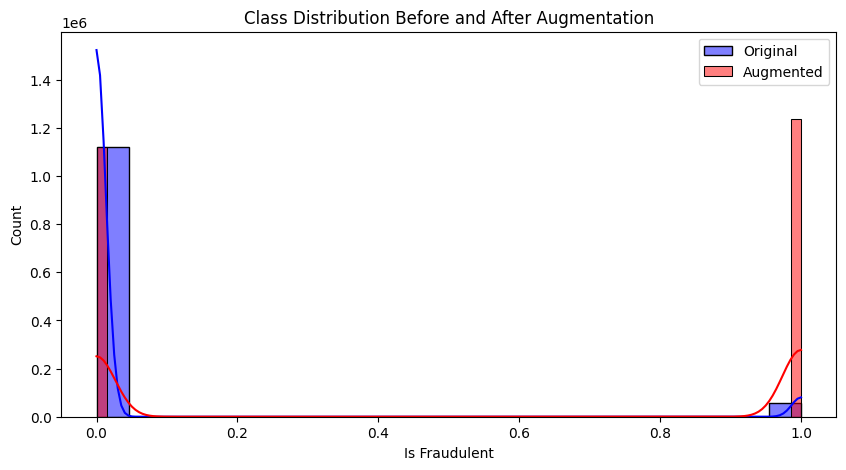

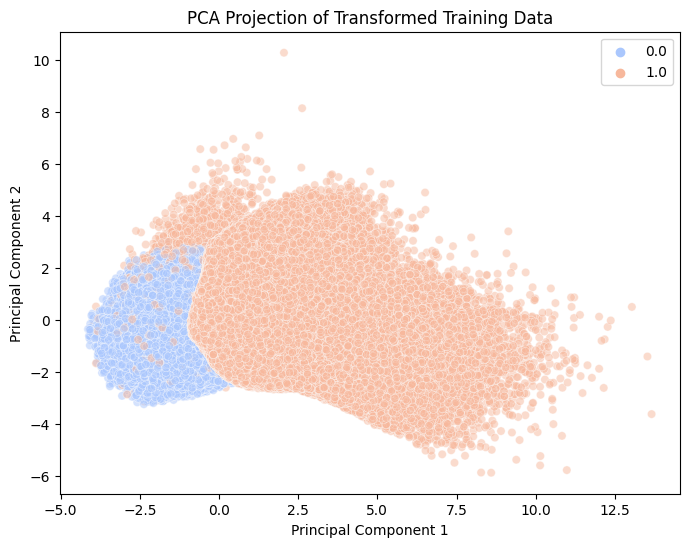

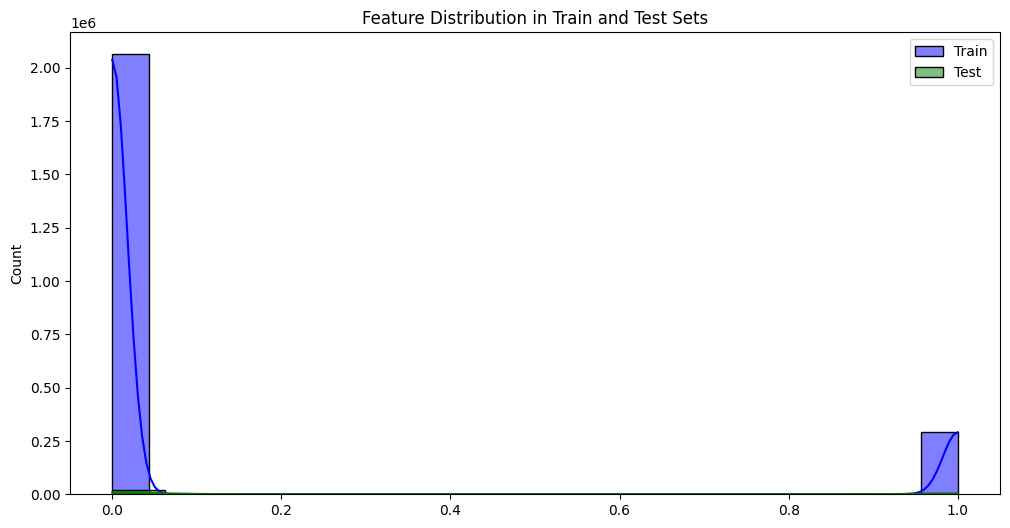

In [16]:
from sklearn.decomposition import PCA

# Print dataset shapes
print("X_train_selected shape:", X_train_selected.shape)
print("y_train shape:", y_train.shape)
print("Synthetic sample count:", num_synthetic_samples)
print("X_synthetic_df shape:", X_synthetic_df.shape)
print("Synthetic labels shape:", synthetic_labels.shape)
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("X_train_augmented shape (before transform):", X_train_augmented.shape)
print("y_train_augmented shape (before transform):", y_train_augmented.shape)

X_train_transformed = preprocessor.fit_transform(X_train_augmented)

print("X_train_transformed shape (after transform):", X_train_transformed.shape)
print("y_train_augmented shape (after transform):", y_train_augmented.shape)
print("Final X_train shape:", X_train_transformed.shape)
print("Final y_train shape:", y_train_augmented.shape)
print("y_train length:", len(y_train_augmented))
print("X_train_transformed length:", len(X_train_transformed))
print("y_test length:", len(test_df['Is Fraudulent']))
print("X_test_transformed length:", len(X_test_transformed))

# Visualization 1: Class distribution before and after augmentation
plt.figure(figsize=(10, 5))
sns.histplot(y_train, label="Original", kde=True, color="blue", alpha=0.5)
sns.histplot(y_train_augmented, label="Augmented", kde=True, color="red", alpha=0.5)
plt.title("Class Distribution Before and After Augmentation")
plt.legend()
plt.show()

# Visualization 2: PCA projection of training data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_transformed)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train_augmented, palette="coolwarm", alpha=0.5)
plt.title("PCA Projection of Transformed Training Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Visualization 3: Train vs. Test feature distribution
plt.figure(figsize=(12, 6))
sns.histplot(X_train_transformed[:, 0], label="Train", kde=True, color="blue", alpha=0.5)
sns.histplot(X_test_transformed[:, 0], label="Test", kde=True, color="green", alpha=0.5)
plt.title("Feature Distribution in Train and Test Sets")
plt.legend()
plt.show()

# **Comparing result against SMOTE and GAN**


Comparison of SMOTE vs GAN:
                 Model  Accuracy (SMOTE)  Accuracy (GAN)
0        Random Forest          0.946602        0.954176
1  Logistic Regression          0.718330        0.927647
2              XGBoost          0.952526        0.953922


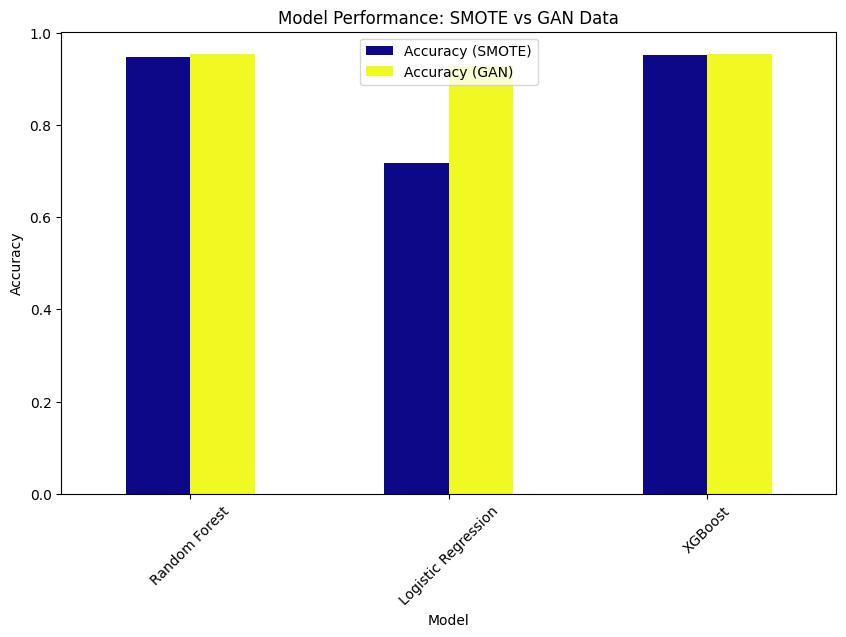

In [17]:
# Create SMOTE vs GAN comparison
comparison_smote_gan_df = pd.DataFrame({
    "Model": [r[0] for r in results_gan],
    "Accuracy (SMOTE)": [r[1] for r in results_smote],
    "Accuracy (GAN)": [r[1] for r in results_gan],
})

print("\nComparison of SMOTE vs GAN:")
print(comparison_smote_gan_df)
comparison_smote_gan_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="plasma")
plt.title("Model Performance: SMOTE vs GAN Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

# **Comparing model performance with Original vs SMOTE vs GAN**


Comparison of Original vs SMOTE vs GAN:
                 Model  Accuracy (Original)  Accuracy (SMOTE)  Accuracy (GAN)
0        Random Forest             0.953880          0.946602        0.954176
1  Logistic Regression             0.953203          0.718330        0.927647
2              XGBoost             0.954134          0.952526        0.953922


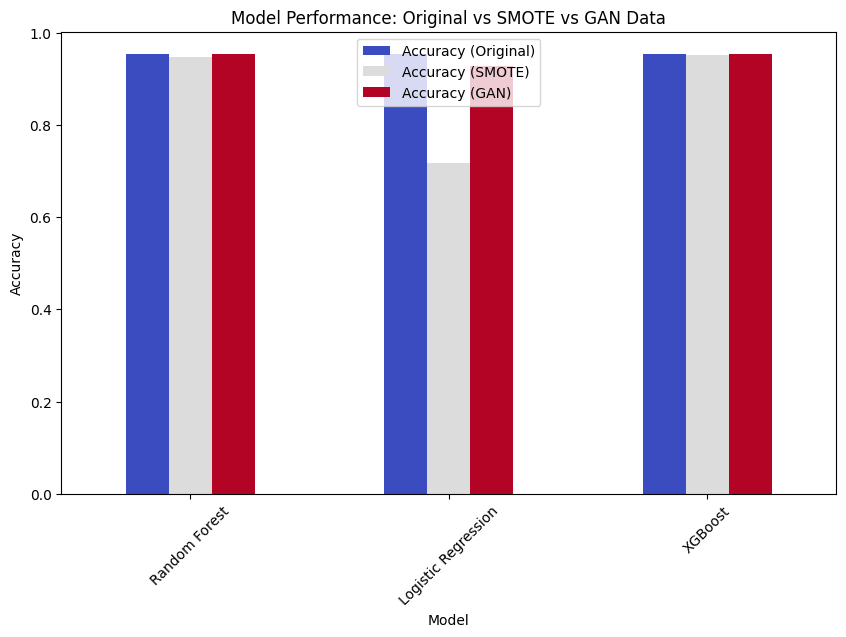

In [18]:
# Create Original vs SMOTE vs GAN comparison
comparison_full_df = pd.DataFrame({
    "Model": [r[0] for r in results_gan],
    "Accuracy (Original)": [r[1] for r in results_original],
    "Accuracy (SMOTE)": [r[1] for r in results_smote],
    "Accuracy (GAN)": [r[1] for r in results_gan],
})

print("\nComparison of Original vs SMOTE vs GAN:")
print(comparison_full_df)
comparison_full_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="coolwarm")
plt.title("Model Performance: Original vs SMOTE vs GAN Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()